# Future Sales Predictions : 

In [5]:
# importing libraries : 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb


In [6]:
# Getting required datasets :
sales_train = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
items_cat = pd.read_csv('item_categories.csv')

In [7]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
items_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
sales_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [12]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [13]:
# Now we have taken a view on the datasets buts its not convinient to visualize all at the same time , so lets combine or join 
# all in one dataset :
item_merged = pd.merge(items,items_cat,how='inner')
shop_merged = pd.merge(sales_train,shops,on='shop_id')
train_data = pd.merge(item_merged,shop_merged,on='item_id')
train_data.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day,shop_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0,"Химки ТЦ ""Мега"""
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0,"Химки ТЦ ""Мега"""
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0,"Химки ТЦ ""Мега"""
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0,"Химки ТЦ ""Мега"""
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0,"Химки ТЦ ""Мега"""


In [14]:
# Now above data has some duplicate rows , so lets remove these :
train_data.drop(train_data[train_data.duplicated()].index,axis=0,inplace=True)

In [15]:
# Groupby function use to group the data with the packet of date_block_num,shop_id,item_id and count the item_cnt_day 
# to find out item count in month :
temp_data = train_data.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day' : 'count'})
temp_data.reset_index(inplace=True)
temp_data = temp_data.set_index('date_block_num')
temp_data.head()

,shop_id,item_id,item_cnt_day
date_block_num,,,
0,0,32,4
0,0,33,3
0,0,35,1
0,0,43,1
0,0,51,2


# Now the data is ready for to do some EDA work

<AxesSubplot:xlabel='item_id'>

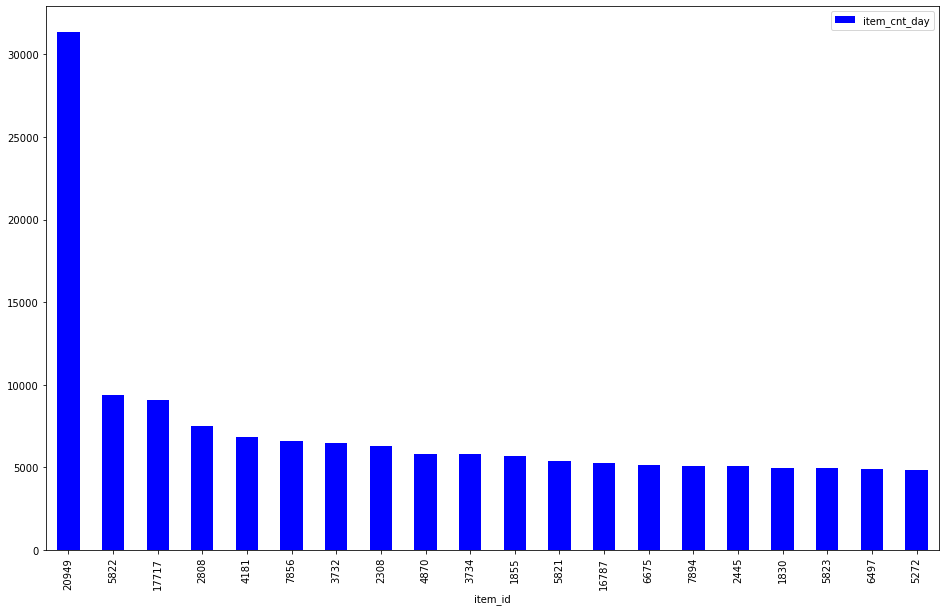

In [16]:
# Checking Which item sold the most

plt.figure(figsize=(16,10))
temp_data.groupby('item_id')['item_cnt_day'].sum().sort_values(ascending=False)[0:20].plot(kind='bar',legend=True,color='blue')

<AxesSubplot:xlabel='shop_id'>

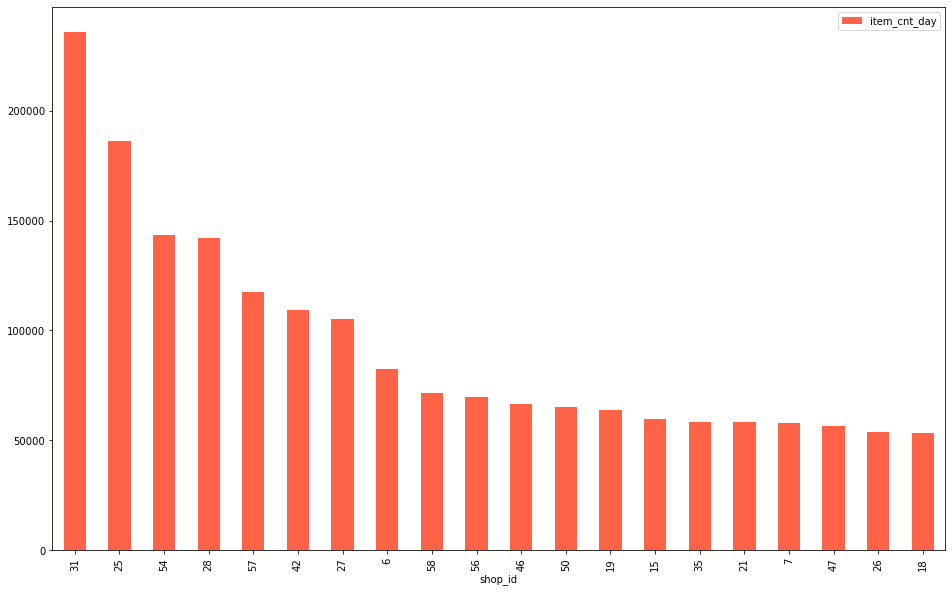

In [17]:
# Checking which shop sold the items most

plt.figure(figsize=(16,10))
temp_data.groupby('shop_id')['item_cnt_day'].sum().sort_values(ascending=False)[0:20].plot(kind='bar',legend=True,color='tomato')

In [18]:
# Our Month Column is in form of Str. so first convert it into datetime form

train_data['date'] = pd.to_datetime(train_data['date'], format = '%d.%m.%Y')
train_data['Month'] = train_data['date'].dt.to_period('M')
train_data['Month'] = train_data['Month'].astype(str)

In [19]:
# Now we have all the Months+year column named Month, now applying groupby to count the item_cnt_day for whole month

temp_data = train_data.groupby(['shop_id','item_id','Month']).agg({'item_cnt_day' : 'sum'})
temp_data.reset_index(inplace=True)
temp_data = temp_data.set_index('Month')
temp_data.rename(columns = {'item_cnt_day' : 'item_cnt_month'},inplace=True)
temp_data.head()

,shop_id,item_id,item_cnt_month
Month,,,
2013-02,0,30,31.0
2013-02,0,31,11.0
2013-01,0,32,6.0
2013-02,0,32,10.0
2013-01,0,33,3.0


<AxesSubplot:xlabel='Month'>

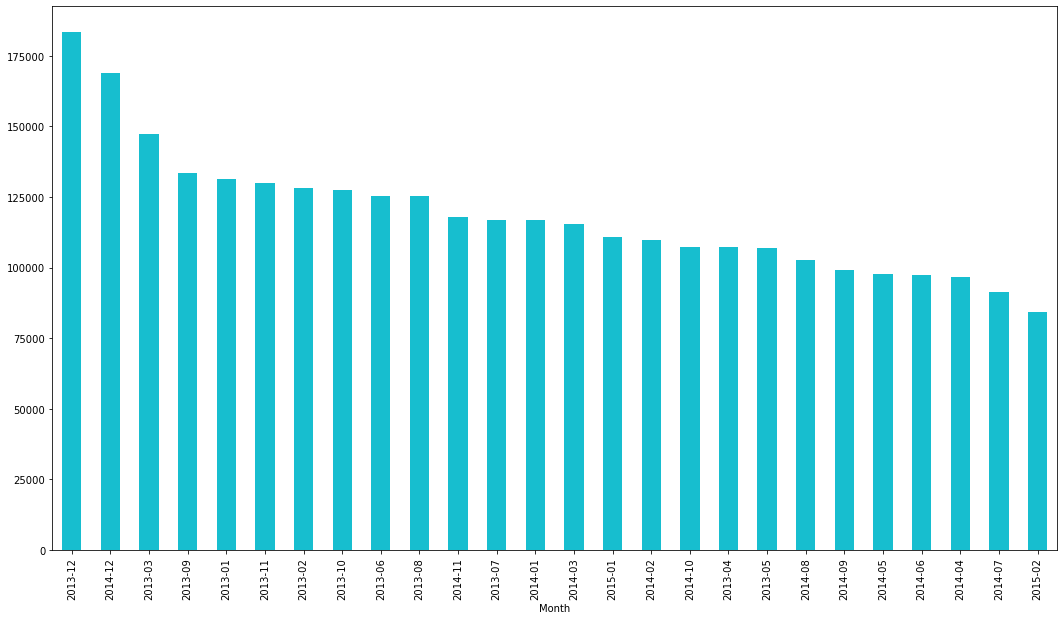

In [21]:
# Checking which Month with year selling the Most

plt.figure(figsize=(18,10))
temp_data.groupby('Month')['item_cnt_month'].sum().sort_values(ascending=False)[:26].plot(kind='bar',color='tab:cyan')


<AxesSubplot:xlabel='Month'>

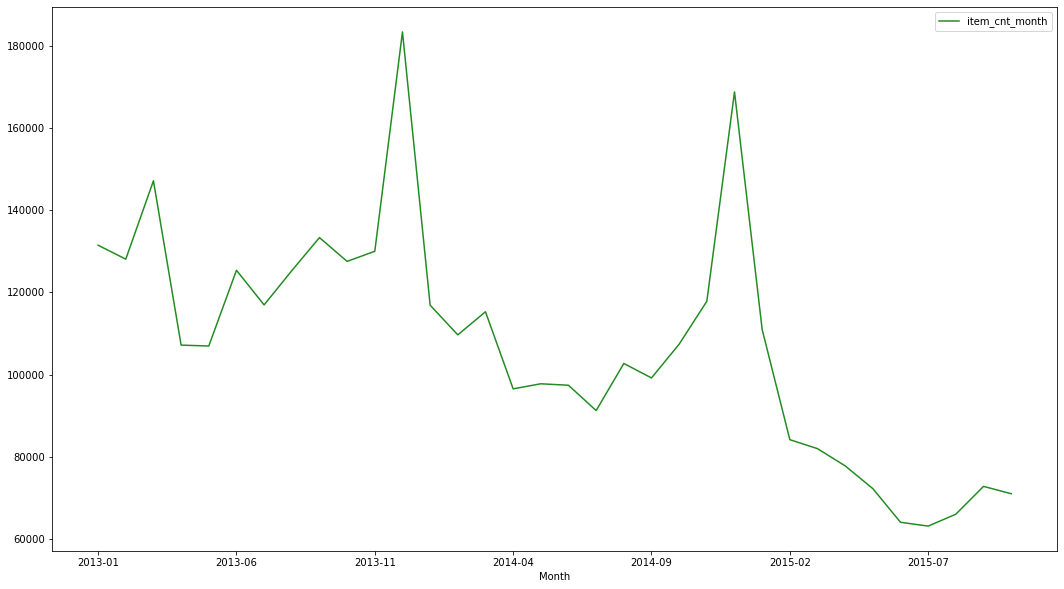

In [22]:
plt.figure(figsize=(18,10))
temp_data.groupby('Month')['item_cnt_month'].sum().plot(legend=True,color='forestgreen')

In [23]:
 #So we determine that Last Months like November, December with different years have most selling

temp_data.reset_index(inplace=True)
temp_data.tail(5)


,Month,shop_id,item_id,item_cnt_month
1609119,2015-04,59,22164,2.0
1609120,2015-07,59,22164,1.0
1609121,2013-10,59,22167,1.0
1609122,2013-12,59,22167,2.0
1609123,2014-06,59,22167,1.0


# Model Building : 

In [25]:
X = temp_data.iloc[:,:-1]
y = temp_data.iloc[:,-1:]


In [26]:
le = LabelEncoder()
X['Month']= le.fit_transform(X['Month'])
X

,Month,shop_id,item_id
0,1,0,30
1,1,0,31
2,0,0,32
3,1,0,32
4,0,0,33
...,...,...,...
1609119,27,59,22164
1609120,30,59,22164
1609121,9,59,22167
1609122,11,59,22167


In [27]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
x_train.head()

,Month,shop_id,item_id
67532,7,5,3186
1318666,10,52,13439
441757,16,22,12860
398874,22,21,5663
1113159,9,44,17181


In [30]:
# Using XGBRegressor with different hyperparameter tuning

xg = xgb.XGBRegressor(base_score=0.5,
                      n_estimators=400,
                      min_child_weight=1,
                     max_depth=7,
                     learning_rate=0.1,
                     booster='gbtree',
                     tree_method='exact',
                     reg_alpha=0,
                     subsample=0.5,
                     validate_parameters=1,
                     colsample_bylevel=1,
                     colsample_bynode=1,
                     colsample_bytree=1,
                     gamma=0)


In [ ]:
xg.fit(x_train,y_train)

In [ ]:
xg.score(x_test,y_test)

In [ ]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
test.set_index('ID',inplace=True)
test['Month'] = 34

In [ ]:
pred = xg.predict(test)
test['item_cnt_month'] = (pred[0]*len(test))/len(test)

In [ ]:
sub = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
test.reset_index(inplace=True)
sub = test.drop(['shop_id','item_id','Month'],axis=1)

In [ ]:
sub.to_csv('submission.csv',index=False)
subb = pd.read_csv('./submission.csv')
subb.head()